In this example, we consider the simplest two-level system. First, we define the system and plot the energy levels. Following that, a Rabi oscillation is simulated for two different pulse vectors, with the results being fitted and plotted in the Bloch sphere. Lastly, we simulated a Hahn echo decay for a modelled collapse operator.

**Table of contents**<a id='toc0_'></a>    
- 1. [Defining the Spin 1/2 System](#toc1_)    
- 2. [Rabi Oscillation](#toc2_)    
- 3. [Hahn Echo](#toc3_)    
  - 3.1. [Custom sequence](#toc3_1_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import numpy as np
from qutip import sigmax, sigmay, sigmaz, fock_dm

from quaccatoo import QSys, PulsedSim, Analysis, fit_rabi, Rabi, Hahn, square_pulse

# 1. <a id='toc1_'></a>[Defining the Spin 1/2 System](#toc0_)

We begin defining a general two-level system with a time independent Hamiltonian given by
$$ H_0 = \frac{\Delta}{2} \sigma_z ,$$ 
where $\Delta$ is the energy difference between the two levels and $\sigma_z$ the Pauli matrix. Although simple, this Hamiltonian can represent a varied number of systems: from spin-1/2 nuclear spins in NMR, to electronic spins in EPR, to superconducting qubits. Let us assume now that the state is initialized in the state $|0 \rangle$, thus the initial density matrix is
$$ \rho_0 = |0 \rangle \langle 0 | = \begin{pmatrix} 1 & 0 \\ 0 & 0 \end{pmatrix} .$$
Last, we also consider that the system has an observable given by the operator $\sigma_z$.

In [2]:
# here we define delta = 1
delta = 1

# create the QSys object with the desired parameters
qsys = QSys(
    H0 = delta/2 * sigmaz(),
    rho0 = fock_dm(2, 0),
    observable = sigmaz(),
    units_H0 = 'MHz' # sets the Hamiltonian units. By default it is considered to be in frequency units.
)

The energy levels are trivial in this simple case. To visualize them we use the plot_energy method from quaccatoo. Note, that in QSys class, the lowest state energy is subtracted from all the eigenenergies to have the lowest level at 0.

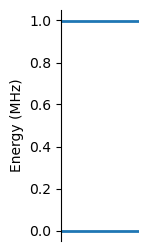

In [3]:
qsys.plot_energy(figsize=(1,3))

# 2. <a id='toc2_'></a>[Rabi Oscillation](#toc0_)

With the quantum system defined, the first measurement to perform is a Rabi oscillation. This is done by applying a resonant pulse to the system with varying length, such that it will drive the system between the two levels causing a period oscillation of the observable expectation value. Let us consider a square cosine pulse of frequency $\Delta$ applied on the x-axis of the laboratory frame. The interaction of the pulse with the system is then described in terms of a control Hamiltonian given by
$$ H_1 = \omega_1 \sigma_x ,$$
which is then multiplied by the time-dependent pulse function. $\omega_1$ is the Rabi frequency, related to the amplitude of the pulse.

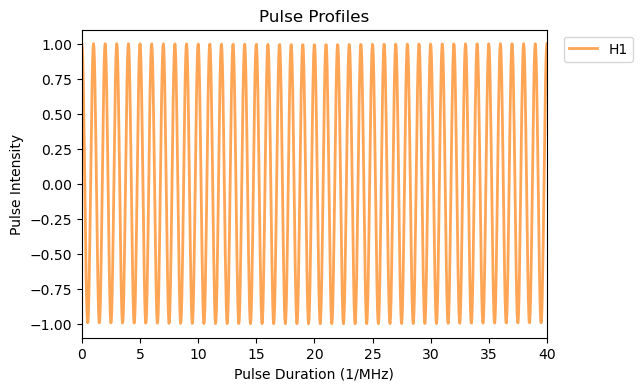

In [4]:
# let's consider a rabi frequency 10 times smaller than the resonance frequency, such that the rotating wave approximation is valid
w1 = 0.1 # in frequency units

# create the Rabi object for the qsys and the desired parameters
rabi_exp = Rabi(
    pulse_duration = np.linspace(0, 40, 1000), # time array of pulse duration which we want to simulate the experiment
    system = qsys, # we pass the qsys object defined in the previous section
    H1 = w1*sigmax(), # the Hamiltonian for the interaction with the pulse
    pulse_shape = square_pulse, # the pulse shape function we want to use (this line is redundant since square_pulse is the default pulse shape function if not specified)
    pulse_params = {'f_pulse': delta}, # we need to pass the the frequency of the pulse as the resonant frequency of the system
)

# to visualize the pulse sequence we can use the plot_pulses method, where we can see the pulse shape and the pulse duration
rabi_exp.plot_pulses()

With the run method the experiment is simulated and the expectation value of the observable is plotted with plot_results.

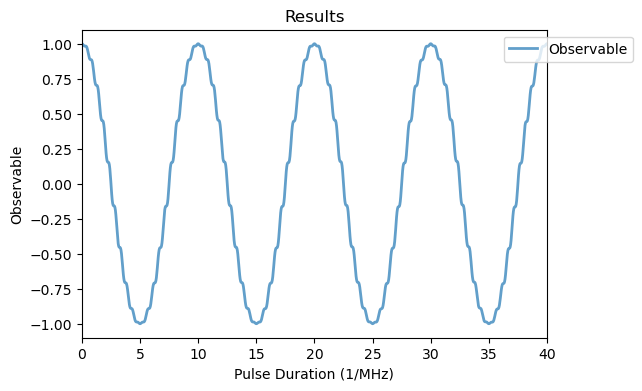

In [5]:
rabi_exp.run()

Analysis(rabi_exp).plot_results()

As expected, the expectation value of the operator shows a period oscillation, but with a small modulation related to the rotating wave approximation as we chose $\Delta/\omega_1=10$. For larger ratios, this modulation disappears (check yourself!). Now to fit the data we use the Analysis class.

array([ 9.98110230e-01,  5.00156758e+00, -6.25532528e-04, -3.41312786e-06])

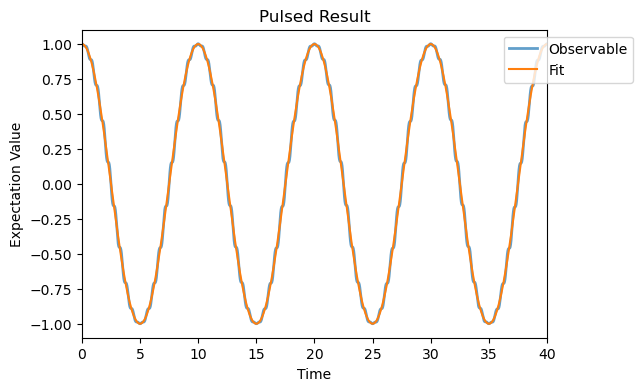

In [6]:
# create the Analysis object for the Rabi experiment
rabi_analysis = Analysis(rabi_exp)

# fit the Rabi oscillations with the run_fit method
rabi_analysis.run_fit(
    fit_function = fit_rabi, # here we use the predefined fit_rabi function
    guess = [1, 1/2/w1, 0, 0], # we can provide an initial guess for the fit parameters, check the Analysis module for the order of the parameters
    )
# plot the results of the fit
rabi_analysis.plot_fit()

# check the fit results
rabi_analysis.fit

Here we observe that the fitted value of the $\pi$-pulse duration $t_\pi \cong 5.001$ is slightly larger than the expected value of $1/(2 \omega_1) = 5$. To obtain a more accurate value, we can consider a rotating pulse with two control Hamiltonians $\sigma_x$ and $\sigma_y$, for that we define custom pulse shape for X and Y with a dephasing of $\pi/2$ as follows.

array([ 9.99988097e-01,  5.00000180e+00, -4.78250060e-07, -8.28958462e-06])

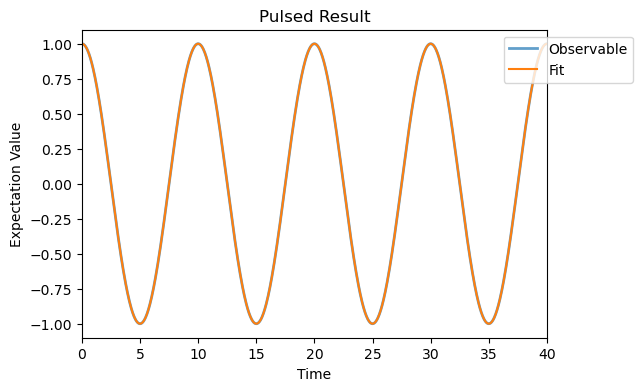

In [7]:
# define a custom pulse shape for X
def custom_pulseX(t):
    return np.cos(delta*t)

# define a custom pulse shape for Y
def custom_pulseY(t):
    return np.cos(delta*t - np.pi/2)

# create the new Rabi object for the qsys and the desired parameters
rabi_exp_2 = Rabi(
    pulse_duration = np.linspace(0, 40, 1000), # time array of pulse duration which we want to simulate the experiment
    system = qsys, # we pass the qsys object defined in the previous section
    H1 = [w1*sigmax()/2, w1*sigmay()/2], # the Hamiltonian for the interaction with the pulse now is a list with the two control Hamiltonians for X and Y
    pulse_shape = [custom_pulseX, custom_pulseY] # for the pulse_shape we pass a list with the two custom pulse shape functions, as now the custom pulses have no other parameters and pulse_params dictionary is empty
)

# run the experiment
rabi_exp_2.run()
# call Analysis class
rabi_analysis_2 = Analysis(rabi_exp_2)

# fit the Rabi oscillations with the run_fit method same as before
rabi_analysis_2.run_fit(
    fit_function = fit_rabi,
    guess = [1, 1/2/w1, 0, 0]
    )

# plot the results of the fit
rabi_analysis_2.plot_fit()

# check the fit results
rabi_analysis_2.fit

In the rotating frame of reference, this new rotating pulse is fully aligned within the $x$-axis. Thus, the modulations have disappeared and the $t_\pi$ value is closer to the expected value of $1/(2\omega_1)$. Another useful way to visualize the Rabi oscillation is through the Bloch sphere representation, as shown bellow. In the rotating frame, the Bloch vector rotates around the $x$-axis. However, in the laboratory frame, it rotates in a spiral.

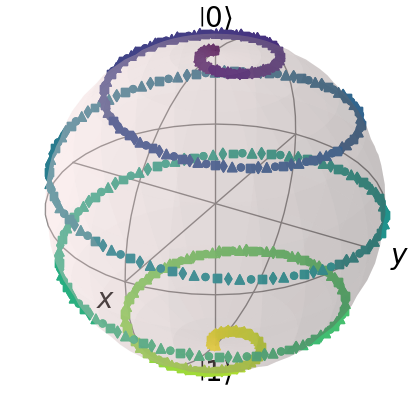

In [8]:
rabi_exp_3 = Rabi(
    pulse_duration = np.linspace(0, 1/2/w1, 500), # In this case we define a pulse duration array which goes up to a pi-pulse
    system = qsys, 
    H1 = [w1*sigmax()/2, w1*sigmay()/2],
    pulse_shape = [custom_pulseX, custom_pulseY]
)

# run the experiment
rabi_exp_3.run()
# call Analysis class
rabi_analysis_3 = Analysis(rabi_exp_3)

# plot the Bloch sphere representation of the results
rabi_analysis_3.plot_bloch()

# 3. <a id='toc3_'></a>[Hahn Echo](#toc0_)

Another important quantity in quantum systems is the coherence time $T_2$, being a measure of how fast a system loses its quantum information, or in other words, how fast it becomes classical. To model the non-unitary process which causes quantum decoherence we make use of the Lindblad master equation from Qutip, by defining a collapse operator
$$ C = \gamma \sigma_z ,$$
Where $\gamma$ is rate of decoherence, inversely proportional to $T_2$. The Hahn echo sequence is then used to measure the coherence time, being composed of two free evolutions with a refocusing $\pi$-pulse in between. An initial and final $\pi/2$-pulse are also included in order to project the spin the quantization axis.

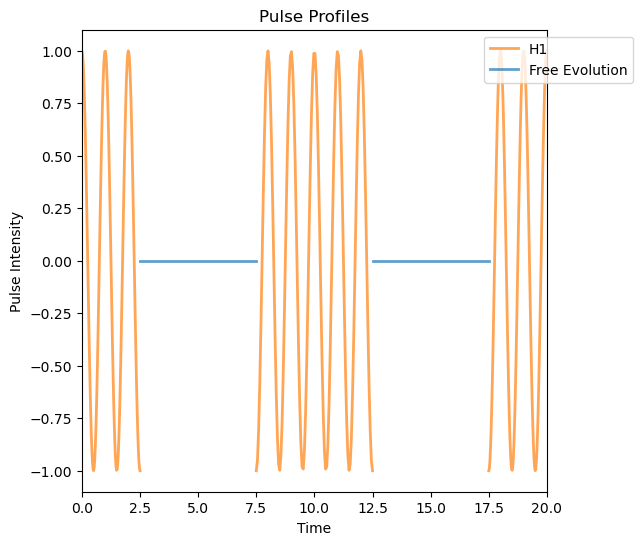

In [9]:
# define an arbitrary gamma
gamma = 0.1

# overwrite the c_ops attribute of the QSys object
qsys.c_ops = gamma * sigmaz()

hahn_exp = Hahn(
    free_duration = np.linspace(5, 25, 30), # define the array of free durations to simulate
    pi_pulse_duration= 1/2/w1, # define the pi pulse duration
    projection_pulse=True, # include the pi/2 pulse after the second free evolution (this line is redundant since it is the default value) !!! The projection pulse is the last pi/2-pulse. It is only present in NV measurements. The first one that is needed to bring the spin to the equator plane is used in NV experiments as well as in EPR/NMR experiments. Therefore, it is better to keep the first pulse always included, while leaving the last pulse optional !!!
    # same parameters as before
    system = qsys,
    H1 = w1*sigmax(), 
    pulse_shape=square_pulse,
    pulse_params = {'f_pulse': delta}
)

# plot the pulse sequence
hahn_exp.plot_pulses(tau=10)

In this case, we can observe the initial and final $\pi/2$ pulses, the two free evolutions and the middle $\pi$-pulse. Finaly, running the experiment leads to an exponential decay of the observable expectation value, known as the Hahn echo decay.

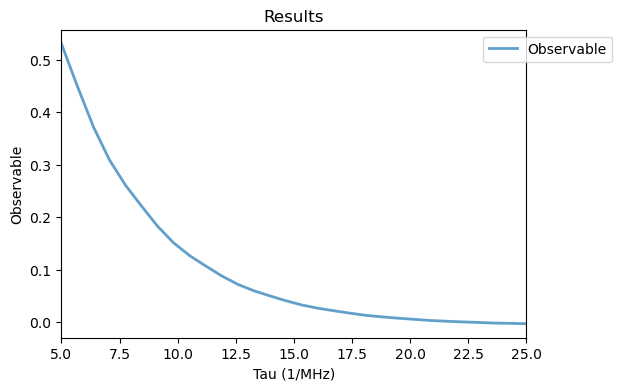

In [10]:
# run the experiment and plot the result
hahn_exp.run()
Analysis(hahn_exp).plot_results()

## 3.1. <a id='toc3_1_'></a>[Custom sequence](#toc0_)

Let's say now that we want to end the Hahn echo sequence with $3\pi/2$ pulse instead of $\pi/2$. This sequence is not predefined in quaccatoo, but the user can define it as bellow.

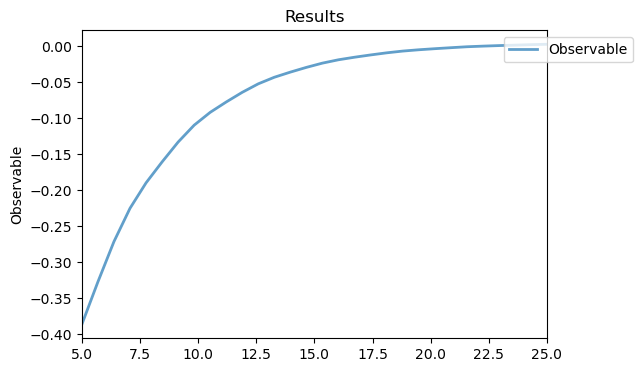

In [11]:
t_pi = 1/2/w1

# the custom sequence needs to be defined as a python function of a controlled variable, in this case of the free evolution time tau
def custom_Hahn(tau):
    
    ps = tau - t_pi # calculate pulse separation time !!! pulse separation time is tau - length of a pi-pulse !!!

    seq = PulsedSim(qsys) # we start initializing the sequence
    # we add the first pi/half pulse with the add_pulse method
    seq.add_pulse(duration=t_pi/2, H1=w1*sigmax(), pulse_shape=square_pulse, pulse_params = {'f_pulse': delta})
    # then we add a free evolution with the add_free_evolution method
    seq.add_free_evolution(duration=ps)
    seq.add_pulse(duration=t_pi, H1=w1*sigmax(), pulse_shape=square_pulse, pulse_params = {'f_pulse': delta})
    seq.add_free_evolution(duration=ps)
    seq.add_pulse(duration=3*t_pi/2, H1=w1*sigmax(), pulse_shape=square_pulse, pulse_params = {'f_pulse': delta})

    # return the final state
    return seq.rho

custom_seq = PulsedSim(qsys)
# in this case the run method should be specified with the variable and sequence
custom_seq.run(variable=np.linspace(5, 25, 30), sequence=custom_Hahn)
Analysis(custom_seq).plot_results()

In this case thus, the expectation value start from negatives values then decays to 0 due to the final $3\pi/2$ pulse.